In [ ]:
INPUT Shape= 224*224 

In [2]:
# Importing Tools & Libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, f1_score, PrecisionRecallDisplay

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

from tensorflow.keras.metrics import Precision, Recall
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [3]:
# Loading Dataset Labels

train_df = pd.read_csv('/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/train/_annotations.csv')
test_df = pd.read_csv('/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/test/_annotations.csv')
valid_df = pd.read_csv('/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/valid/_annotations.csv')

In [4]:
# Creating Image DataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
# Training data generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/train',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 28518 validated image filenames belonging to 6 classes.


In [6]:
# Validation data generator

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/valid',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 3581 validated image filenames belonging to 6 classes.


In [7]:
# Test data generator

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/test',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 3466 validated image filenames belonging to 6 classes.


In [8]:
# Confirmation split Samples

print(f"Training samples: {len(train_generator.filenames)}")
print(f"Validation samples: {len(valid_generator.filenames)}")
print(f"Test samples: {len(test_generator.filenames)}")

Training samples: 28518
Validation samples: 3581
Test samples: 3466


In [9]:
# Loading vgg16 model Also Fine-Tuning the Fully-connected Layer

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(460, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(56, activation='relu')(x)
x = Dense(188, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    # Define the optimizer with a custom learning rate
    custom_learning_rate = 0.0003102
    optimizer = Adam(learning_rate=custom_learning_rate)

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 460)            │    11,540,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 460)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │        25,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 188)            │        10,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,13

 Total params: 26,293,294 (100.30 MB)

 Trainable params: 11,578,606 (44.17 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
# Model Training

history_vgg16 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // valid_generator.batch_size,
    epochs=20
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718746214.414424     504 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718746214.434529     504 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


192/445 ━━━━━━━━━━━━━━━━━━━━ 2:06 500ms/step - accuracy: 0.4400 - loss: 3.0619

W0000 00:00:1718746310.044432     502 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.5236 - loss: 2.0863

W0000 00:00:1718746389.593516     502 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


445/445 ━━━━━━━━━━━━━━━━━━━━ 256s 431ms/step - accuracy: 0.5238 - loss: 2.0843 - val_accuracy: 0.7293 - val_loss: 0.7153
Epoch 2/20
  1/445 ━━━━━━━━━━━━━━━━━━━━ 1:53 256ms/step - accuracy: 0.6875 - loss: 0.6787

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1718746463.425342     503 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


445/445 ━━━━━━━━━━━━━━━━━━━━ 58s 129ms/step - accuracy: 0.6875 - loss: 0.6787 - val_accuracy: 0.7377 - val_loss: 0.6147
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 152s 337ms/step - accuracy: 0.7198 - loss: 0.7115 - val_accuracy: 0.7520 - val_loss: 0.6379
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - accuracy: 0.7812 - loss: 0.6614 - val_accuracy: 0.7541 - val_loss: 0.6603
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 153s 338ms/step - accuracy: 0.7541 - loss: 0.6186 - val_accuracy: 0.7713 - val_loss: 0.5547
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step - accuracy: 0.7500 - loss: 0.5704 - val_accuracy: 0.7869 - val_loss: 0.5034
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 159s 352ms/step - accuracy: 0.7647 - loss: 0.5717 - val_accuracy: 0.7545 - val_loss: 0.5529
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 1s 578us/step - accuracy: 0.7656 - loss: 0.5632 - val_accuracy: 0.7541 - val_loss: 0.5961
Epoch 9/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 162s 358ms/step - accuracy: 0.7658 - loss: 0.5597 - va

In [13]:
def plot_history(history, title):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
    
  

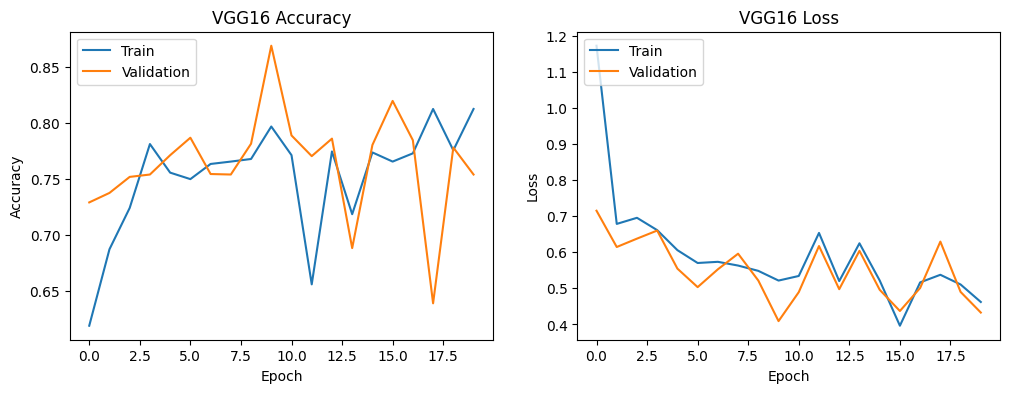

In [23]:
  # Plot Training history for VGG16
    
plot_history(history_vgg16,"VGG16")

In [16]:
# Model Evaluation
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 326ms/step - accuracy: 0.7842 - loss: 0.4717
Test loss: 0.4679499864578247
Test accuracy: 0.7870370149612427


In [17]:
# Printing Classification Report

test_generator.reset()
preds = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

 1/55 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step

W0000 00:00:1718748000.838431     502 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 541ms/step
              precision    recall  f1-score   support

        crab       0.37      0.42      0.40      1279
        fish       0.09      0.04      0.05       321
   jellyfish       0.03      0.02      0.02        62
      shrimp       0.00      0.00      0.00        57
  small_fish       0.27      0.31      0.29       965
    starfish       0.21      0.18      0.20       782

    accuracy                           0.29      3466
   macro avg       0.16      0.16      0.16      3466
weighted avg       0.27      0.29      0.28      3466



W0000 00:00:1718748030.074761     504 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


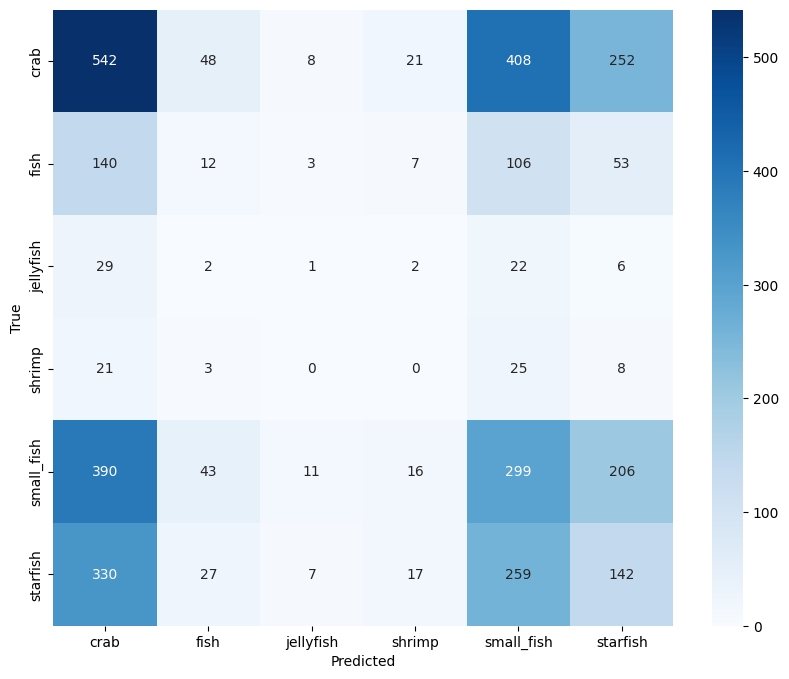

In [18]:
# Plotting Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [19]:
# Printing precision, Recall, F1 score

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.269000687605671
Recall: 0.2873629544143104
F1 Score: 0.2758463505457516


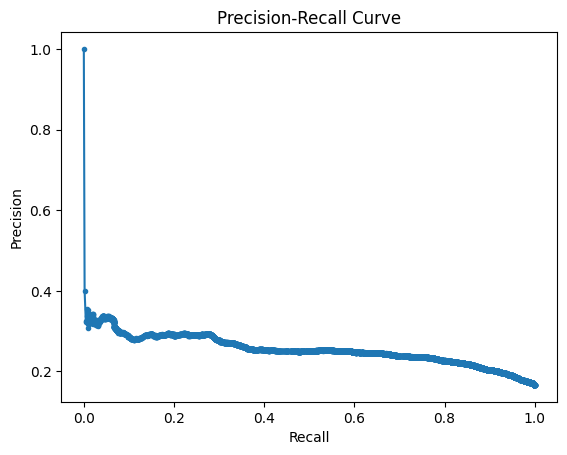

In [20]:
# Plot precision-recall curve

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the output for precision-recall curve
y_test_bin = label_binarize(y_true, classes=list(test_generator.class_indices.values()))
y_score_bin = preds

precision_curve, recall_curve, _ = precision_recall_curve(y_test_bin.ravel(), y_score_bin.ravel())

plt.figure()
plt.plot(recall_curve, precision_curve, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [21]:
# Save the VGG16 model

model.save('Vgg16_Brackish(78.70%).h5')

In [ ]:
def plot_history(history, title):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
    
    

In [ ]:
# Plot history for VGG16
    
    plot_history(history_vgg16,'VGG16')